In [60]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import roc_auc_score, make_scorer
from spellchecker import SpellChecker
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [61]:
spell = SpellChecker()
def clean_text(text):
        text = text.lower()

        text = ''.join([char if char.isalpha() or char.isspace() else '' for char in text])

        corrected_words = [spell.correction(word) if spell.correction(word) is not None else word for word in text.split()]

        text = ' '.join(corrected_words)

        return text

In [62]:
data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))


N, n_cols = x_train_df.shape
print("Shape of x_train_df: (%d, %d)" % (N,n_cols))
print("Shape of y_train_df: %s" % str(y_train_df.shape))

# Print out the first five rows and last five rows
tr_text_list = x_train_df['text'].values.tolist()
rows = np.arange(0, 5)
for row_id in rows:
    text = tr_text_list[row_id]
    print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id,0], text))

print("...")
rows = np.arange(N - 5, N)
for row_id in rows:
    text = tr_text_list[row_id]
    print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id,0], text))

Shape of x_train_df: (2400, 2)
Shape of y_train_df: (2400, 1)
row     0 | y = 0 | Oh and I forgot to also mention the weird color effect it has on your phone.
row     1 | y = 0 | THAT one didn't work either.
row     2 | y = 0 | Waste of 13 bucks.
row     3 | y = 0 | Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with.
row     4 | y = 0 | None of the three sizes they sent with the headset would stay in my ears.
...
row  2395 | y = 1 | The sweet potato fries were very good and seasoned well.
row  2396 | y = 1 | I could eat their bruschetta all day it is devine.
row  2397 | y = 1 | Ambience is perfect.
row  2398 | y = 1 | We ordered the duck rare and it was pink and tender on the inside with a nice char on the outside.
row  2399 | y = 1 | Service was good and the company was better!


In [63]:
# Clean the text data
# x_train_df['cleaned_text'] = x_train_df['text'].apply(clean_text)
# train_sentences = x_train_df['cleaned_text'].tolist()
# y_train = y_train_df['is_positive_sentiment'].values

# just for a progress bar - same as above, but with progress bar
tqdm.pandas()

# Clean the text data with progress trackingc
x_train_df['cleaned_text'] = x_train_df['text'].progress_apply(clean_text)
train_sentences = x_train_df['cleaned_text'].tolist()
y_train = y_train_df['is_positive_sentiment'].values

100%|██████████| 2400/2400 [02:38<00:00, 15.12it/s]


/Users/lukeboshar/y/envs/cs135_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lukeboshar/y/envs/cs135_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lukeboshar/y/envs/cs135_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lukeboshar/y/envs/cs135_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lukeboshar/y/envs/cs135_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lukeboshar/y/envs/cs135_env/

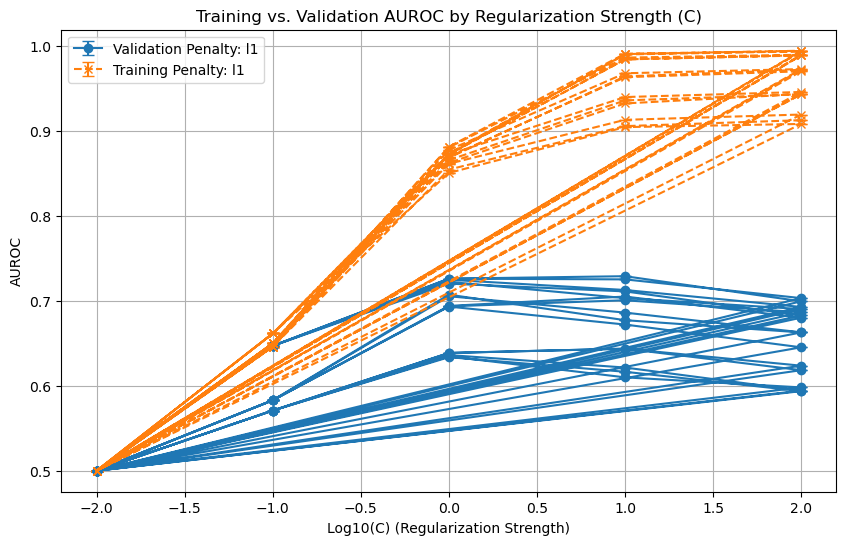

In [80]:
# Define the Logistic Regression model
log_reg = LogisticRegression(solver='liblinear')

# Define the hyperparameter grid for regularization (C) and penalty types
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Different values of regularization strength
    'penalty': ['l1', 'l2'],     # Different penalty types
}

num_folds = [3, 4, 5]
min_counts = [1, 2, 3, 4, 5]

# Use AUROC as the scoring metric
scorer = make_scorer(roc_auc_score, greater_is_better=True)

# Initialize variables to store the best result across different fold searches
best_overall_model = None
best_overall_params = None
best_overall_score = -1
best_combo = None  # To keep track of the number of folds for the best parameters

# Store results for visualization
performance_data = []

# Loop through different values of CV folds
for num_fold in num_folds:
    for min_count in min_counts:
        vectorizer = CountVectorizer(stop_words='english', min_df=min_count, max_df=0.7)
        X_train_bow = vectorizer.fit_transform(train_sentences)

        kf = KFold(n_splits=num_fold)
        grid_search = GridSearchCV(log_reg, param_grid=param_grid, 
                                   scoring=scorer, cv=kf, n_jobs=-1, return_train_score=True)
        grid_search.fit(X_train_bow, y_train)

        # Collect results for plotting
        for params in grid_search.cv_results_['params']:
            param_C = params['C']
            penalty = params['penalty']

            # Collect train and validation scores
            mean_train_score = np.mean(grid_search.cv_results_['mean_train_score'][
                (grid_search.cv_results_['param_C'] == param_C) &
                (grid_search.cv_results_['param_penalty'] == penalty)
            ])
            std_train_score = np.std(grid_search.cv_results_['mean_train_score'][
                (grid_search.cv_results_['param_C'] == param_C) &
                (grid_search.cv_results_['param_penalty'] == penalty)
            ])
            mean_val_score = np.mean(grid_search.cv_results_['mean_test_score'][
                (grid_search.cv_results_['param_C'] == param_C) &
                (grid_search.cv_results_['param_penalty'] == penalty)
            ])
            std_val_score = np.std(grid_search.cv_results_['mean_test_score'][
                (grid_search.cv_results_['param_C'] == param_C) &
                (grid_search.cv_results_['param_penalty'] == penalty)
            ])

            # Append to performance data
            performance_data.append([num_fold, min_count, param_C, penalty, mean_train_score, std_train_score, mean_val_score, std_val_score])

# After the grid search loop, aggregate the results
performance_df = pd.DataFrame(performance_data, columns=['num_folds', 'min_count', 'C', 'penalty', 'mean_train_score', 'std_train_score', 'mean_val_score', 'std_val_score'])

# Group by C and penalty, then calculate the mean and standard error
aggregated_df = performance_df.groupby(['C', 'penalty']).agg({
    'mean_train_score': 'mean',
    'std_train_score': lambda x: np.sqrt(np.mean(x**2)) / np.sqrt(len(x)),
    'mean_val_score': 'mean',
    'std_val_score': lambda x: np.sqrt(np.mean(x**2)) / np.sqrt(len(x))
}).reset_index()

# Convert performance data to DataFrame for easier plotting
performance_df = pd.DataFrame(performance_data, columns=['num_folds', 'min_count', 'C', 'penalty', 'mean_train_score', 'std_train_score', 'mean_val_score', 'std_val_score'])

# Plotting
plt.figure(figsize=(10, 6))

# Filter for only l1 penalty
l1_data = performance_df[performance_df['penalty'] == 'l1']

# Plot only l1 lines
plt.errorbar(np.log10(l1_data['C']), l1_data['mean_val_score'], 
             yerr=l1_data['std_val_score'], label='Validation Penalty: l1', fmt='o-', capsize=4)
plt.errorbar(np.log10(l1_data['C']), l1_data['mean_train_score'], 
             yerr=l1_data['std_train_score'], label='Training Penalty: l1', fmt='x--', capsize=4)

# Add labels and title
plt.xlabel('Log10(C) (Regularization Strength)')
plt.ylabel('AUROC')
plt.title('Training vs. Validation AUROC by Regularization Strength (C)')
plt.legend()
plt.grid(True)
plt.show()

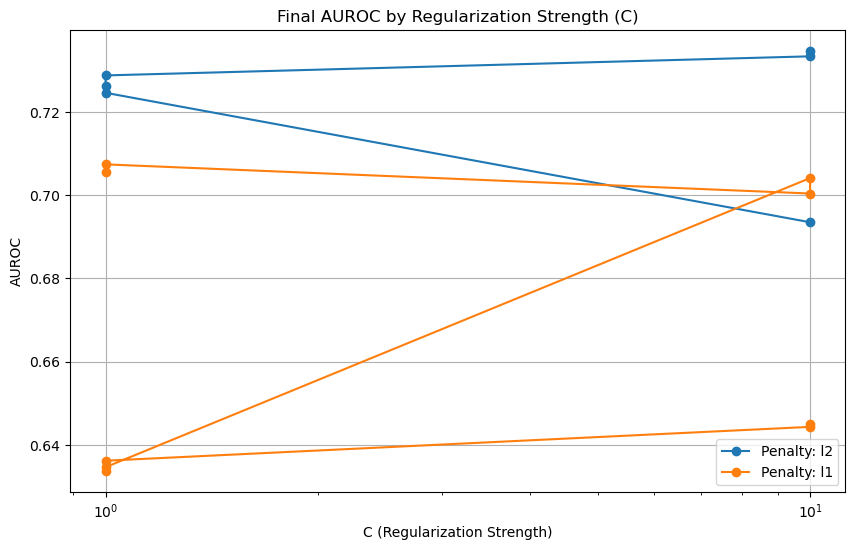

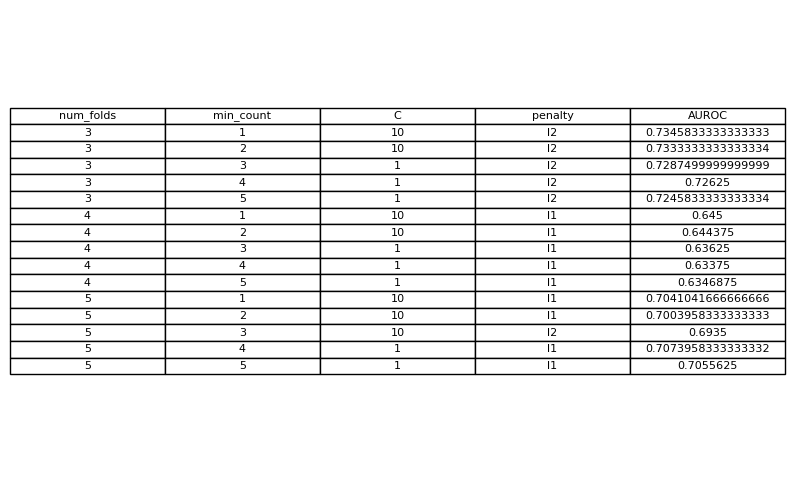


Best parameters overall: {'C': 10, 'penalty': 'l2'}
Best AUROC overall: 0.7345833333333333
Best configuration: {'num_folds': 3, 'min_count': 1}


In [65]:
# After the grid search completes, display the final performance data
df_performance_final = pd.DataFrame(performance_data, columns=['num_folds', 'min_count', 'C', 'penalty', 'AUROC'])

# Plot the final performance data (fewer plots)
plt.figure(figsize=(10, 6))
for penalty in df_performance_final['penalty'].unique():
    subset = df_performance_final[df_performance_final['penalty'] == penalty]
    plt.plot(subset['C'], subset['AUROC'], label=f'Penalty: {penalty}', marker='o')

plt.title('Final AUROC by Regularization Strength (C)')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('AUROC')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Display the final performance DataFrame as a table using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_performance_final.values, colLabels=df_performance_final.columns, cellLoc='center', loc='center')

plt.show()

# Also, print the best results summary for clarity
print(f"\nBest parameters overall: {best_overall_params}")
print(f"Best AUROC overall: {best_overall_score}")
print(f"Best configuration: {best_combo}")

In [66]:
min_freq = best_combo["min_count"]
vectorizer = CountVectorizer(stop_words='english', min_df=min_freq, max_df=0.7)

# Transform the training data into the BoW matrix
X_train_bow = vectorizer.fit_transform(train_sentences)
# Train the final model on the full training data using the best C
final_model = LogisticRegression(C=best_overall_params['C'], solver='liblinear')
final_model.fit(X_train_bow, y_train)

# Apply on test data
x_test_df['cleaned_text'] = x_test_df['text'].progress_apply(clean_text)

# Transform test data using the trained vectorizer
X_test_bow = vectorizer.transform(x_test_df['cleaned_text'].tolist())

# Predict probabilities
y_test_pred = final_model.predict_proba(X_test_bow)[:, 1]


100%|██████████| 600/600 [00:42<00:00, 14.00it/s]


In [67]:
np.savetxt('yproba1_test.txt', y_test_pred, delimiter='\n', fmt='%.6f')  # fmt='%.6f' for six decimal places
print("saved")

saved


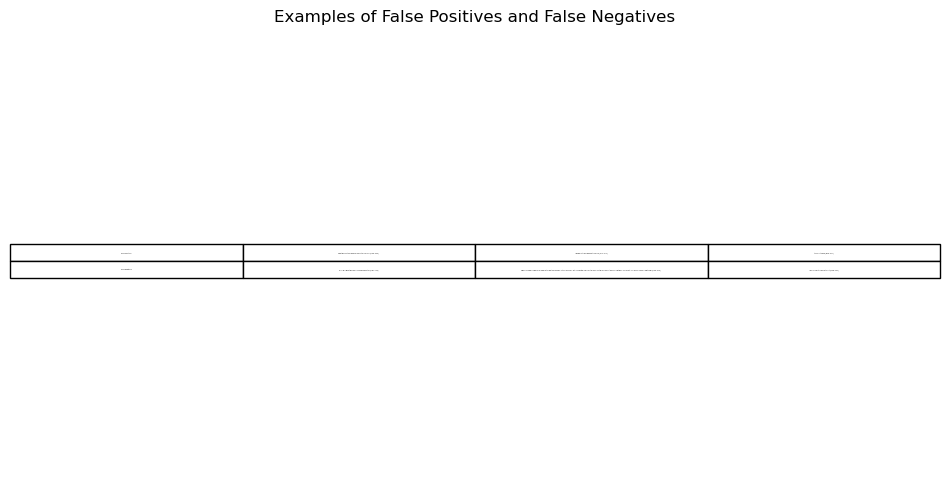

False Positives:
new this location needs a complete overhaul | Predicted Prob: 0.54
i would not recommend this place | Predicted Prob: 0.55
it was not good | Predicted Prob: 0.80

False Negatives:
all in all i give this one a resounding out of | Predicted Prob: 0.43
highly recommended for all ages although the younger set will probably not appreciate some of the more subtle references they will certainly appreciate one galley scene in particular | Predicted Prob: 0.43
i advise you to look out for it | Predicted Prob: 0.31


In [18]:
# Assuming X_val contains the original text data before vectorization (train_sentences)
# Split the original data into train and validation
X_train_text, X_val_text, y_train, y_val = train_test_split(train_sentences, y_train_df['is_positive_sentiment'].values, test_size=0.2, random_state=42)

# Transform the training and validation data into the BoW matrix
X_train_bow = vectorizer.fit_transform(X_train_text)
X_val_bow = vectorizer.transform(X_val_text)

# Train the logistic regression model on the training set
final_model = LogisticRegression(C=best_params['C'], solver='liblinear')
final_model.fit(X_train_bow, y_train)

# Predict probabilities and binary labels on the validation set
y_val_pred_probs = final_model.predict_proba(X_val_bow)[:, 1]
y_val_pred_labels = (y_val_pred_probs >= 0.5).astype(int)

# Compute confusion matrix to identify false positives and false negatives
conf_matrix = confusion_matrix(y_val, y_val_pred_labels)

# Get false positives and false negatives (use original text)
false_positives = [text for text, pred, true in zip(X_val_text, y_val_pred_labels, y_val) if pred == 1 and true == 0]
false_negatives = [text for text, pred, true in zip(X_val_text, y_val_pred_labels, y_val) if pred == 0 and true == 1]

# Get corresponding probabilities for false positives and false negatives
fp_probs = [prob for prob, pred, true in zip(y_val_pred_probs, y_val_pred_labels, y_val) if pred == 1 and true == 0]
fn_probs = [prob for prob, pred, true in zip(y_val_pred_probs, y_val_pred_labels, y_val) if pred == 0 and true == 1]

# Take some representative examples of false positives and false negatives
fp_sample = list(zip(false_positives[:3], fp_probs[:3]))  # First 3 false positives
fn_sample = list(zip(false_negatives[:3], fn_probs[:3]))  # First 3 false negatives

# Plotting representative false positives and false negatives
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Examples of False Positives and False Negatives')
ax.axis('off')

table_data = [
    ['False Positives'] + [f"{text} (Prob: {prob:.2f})" for text, prob in fp_sample],
    ['False Negatives'] + [f"{text} (Prob: {prob:.2f})" for text, prob in fn_sample]
]

# Create table in plot
table = ax.table(cellText=table_data, cellLoc='center', loc='center')

plt.show()

# Print examples for further analysis
print("False Positives:")
for text, prob in fp_sample:
    print(f"{text} | Predicted Prob: {prob:.2f}")

print("\nFalse Negatives:")
for text, prob in fn_sample:
    print(f"{text} | Predicted Prob: {prob:.2f}")
